# Pré-processamento dos dados

## Declaração de bibliotecas e funções

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

sns.set_context("talk")

In [2]:
data_path = 'data/'
model_path = 'models/'
fig_path = 'fig/'

In [3]:
with open(data_path + 'data_with_current.pkl','rb') as f:
    data = pickle.load(f)

In [4]:
data[0].keys()

dict_keys(['V_nom', 'I_nom', 'V_det', 'I_det', 'V_pu', 'I_pu', 'sinal_notch', 'sinal_notch_current', 'sinal_notch_final', 'sinal_notch_final_current', 'faultType', 'V_index', 'I_index'])

In [5]:
data[0]['fault_type']

KeyError: 'fault_type'

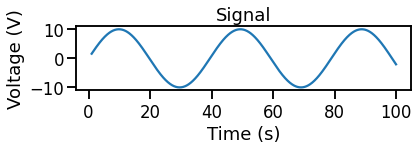

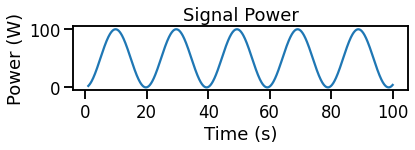

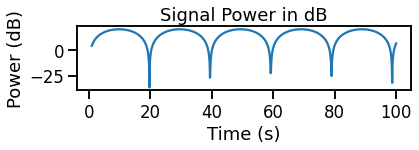

In [5]:
# Signal Generation
t = np.linspace(1, 100, 1000)
x_volts = 10*np.sin(t/(2*np.pi))
plt.subplot(3,1,1)
plt.plot(t, x_volts)
plt.title('Signal')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

x_watts = x_volts ** 2
plt.subplot(3,1,2)
plt.plot(t, x_watts)
plt.title('Signal Power')
plt.ylabel('Power (W)')
plt.xlabel('Time (s)')
plt.show()

x_db = 10 * np.log10(x_watts)
plt.subplot(3,1,3)
plt.plot(t, x_db)
plt.title('Signal Power in dB')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

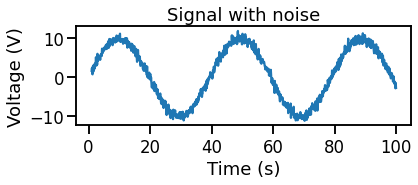

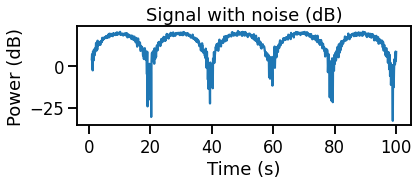

In [6]:
# Adding noise using target SNR

# Set a target SNR
target_snr_db = 20
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
# Noise up the original signal
y_volts = x_volts + noise_volts

# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(t, y_volts)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()
# Plot in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(t, 10* np.log10(y_volts**2))
plt.title('Signal with noise (dB)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

In [7]:
def add_noise(original_signal, snr):
    '''
    Equations:
    [1] SNR = Psignal / Pnoise
    [2] SNRdb = Psignal,db - Pnoise,db
    '''
    # Calculate signal power and convert to dB
    power_signal = original_signal ** 2 
    sig_avg_watts = np.mean(power_signal)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - snr
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(power_signal))
    # Noise up the original signal
    noise_signal = original_signal + noise
    return noise_signal

In [8]:
lista_I = []
for item in data:
    lista_I.append(np.max(item['I_nom'][:3000,:], axis = 0))

In [9]:
I_mean = round(np.mean(lista_I), 0)
I_mean

609.0

In [10]:
len(data)

940

In [11]:
data[0].keys()

dict_keys(['V_nom', 'I_nom', 'V_det', 'I_det', 'V_pu', 'I_pu', 'sinal_notch', 'sinal_notch_current', 'sinal_notch_final', 'sinal_notch_final_current', 'faultType', 'V_index', 'I_index'])

In [12]:
I_pu_data = []
for i, v in enumerate(data):
    I_pu = data[i]['I_det'] / I_mean
    I_pu_data.append({'I_pu': I_pu, 'fault_type': data[i]['faultType']})

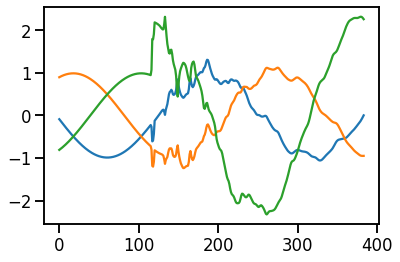

In [13]:
plt.plot(I_pu_data[4]['I_pu']);

In [14]:
final_data = []
for i, v in enumerate(I_pu_data):
    fault_dict = {'fault_type': v['fault_type'], 'I_pu': v['I_pu']}
    for snr in range(30, 110, 10):
        noise_a = add_noise(v['I_pu'][:,0], snr).reshape(-1, 1)
        noise_b = add_noise(v['I_pu'][:,1], snr).reshape(-1, 1)
        noise_c = add_noise(v['I_pu'][:,2], snr).reshape(-1, 1)
        noise_signal = np.concatenate((noise_a, noise_b, noise_c), axis=1)
        fault_dict.update({f'I_{str(snr)}db': noise_signal})
    final_data.append(fault_dict)

In [15]:
len(final_data)

940

In [16]:
final_data[0].keys()

dict_keys(['fault_type', 'I_pu', 'I_30db', 'I_40db', 'I_50db', 'I_60db', 'I_70db', 'I_80db', 'I_90db', 'I_100db'])

In [17]:
final_data[100]['fault_type']

array(['AB'], dtype='<U2')

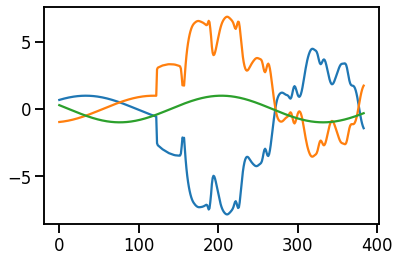

In [18]:
plt.plot(final_data[100]['I_pu']);

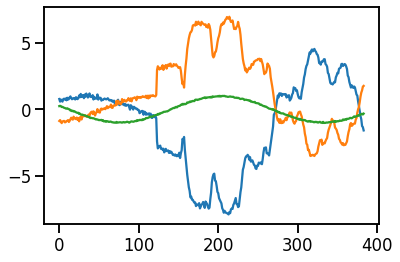

In [19]:
plt.plot(final_data[100]['I_30db']);

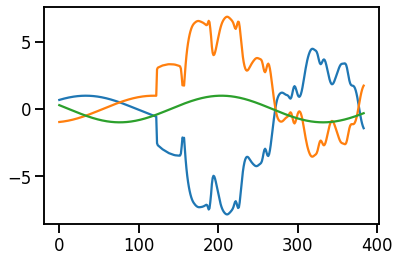

In [20]:
plt.plot(final_data[100]['I_100db']);

In [21]:
def drange(start, stop, step):
    while start < stop:
            yield start
            start *= step

In [22]:
teste = final_data[0]['I_pu'][64:,:]
soma = final_data[0]['I_pu'][64:,:].sum(axis=1).reshape(-1,1)
conca = np.concatenate((teste,soma), axis=1)

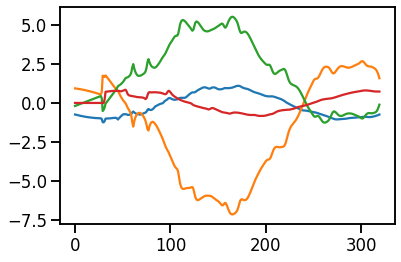

In [23]:
plt.plot(conca);

In [24]:
d = final_data[0]

In [25]:
s = d['I_pu'][64:, :]

In [26]:
final_samples = []
keys = ['I_pu', 'I_30db', 'I_40db', 'I_50db', 'I_60db', 'I_70db', 'I_80db', 'I_90db', 'I_100db']
for data in final_data:
    append_dict = {}
    for n in drange(1, 33, 2):
        data_dict = {}
        for key in keys: 
            # size = int((data[key][128:,:].shape[0] - 64) / n + 64)
            size = int(data[key][128:,:].shape[0] / n)
            signal = data[key][128:, :]
            signal_z = signal.sum(axis=1).reshape(-1,1)
            final = np.concatenate((signal, signal_z), axis=1)
            data_dict[key] = final[:size, :]
        append_dict.update({'fault_type': data['fault_type'][0], 'cycle_' + str(n): data_dict})
    final_samples.append(append_dict)

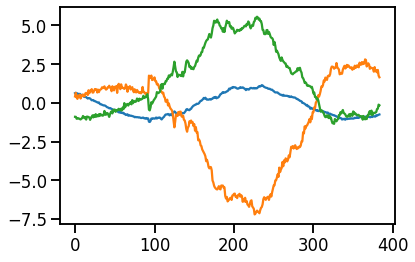

In [27]:
plt.plot(final_data[0]['I_30db']);

In [29]:
len(final_data[0]['I_30db'])

384

In [30]:
final_data[0]['I_30db']

array([[ 0.62599056,  0.41724118, -0.89766319],
       [ 0.65335273,  0.64812322, -0.90018595],
       [ 0.60274046,  0.3473676 , -1.02268379],
       ...,
       [-0.79073961,  2.12983317, -0.37677469],
       [-0.7652608 ,  1.75940396, -0.11349648],
       [-0.74826555,  1.65478779, -0.1543693 ]])

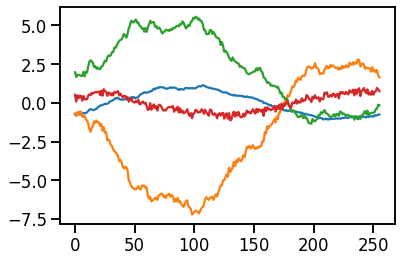

In [28]:
plt.plot(final_samples[0]['cycle_1']['I_30db']);

In [31]:
len(final_samples[0]['cycle_1']['I_30db'])

256

In [32]:
final_samples[0]['cycle_1']['I_30db']

array([[-0.69566734, -0.75693086,  1.97572477,  0.52312658],
       [-0.73435775, -0.84705808,  1.67126649,  0.08985066],
       [-0.74599916, -0.58512997,  1.82488056,  0.49375143],
       ...,
       [-0.79073961,  2.12983317, -0.37677469,  0.96231886],
       [-0.7652608 ,  1.75940396, -0.11349648,  0.88064668],
       [-0.74826555,  1.65478779, -0.1543693 ,  0.75215294]])

In [ ]:
#final_samples = []
#keys = ['I_pu', 'I_30db', 'I_40db', 'I_50db', 'I_60db', 'I_70db', 'I_80db', 'I_90db', 'I_100db']
#for data in final_data:
#    append_dict = {}
#    for n in drange(1, 33, 2):
#        data_dict = {}
#        for key in keys: 
#            size = int((data[key][64:,:].shape[0] - 64) / n + 64)
#            signal = data[key][64:, :]
#            phaseA = signal[:size, 0]
#            phaseB = signal[:size, 1]
#            phaseC = signal[:size, 2]
#            phases = np.hstack([phaseA, phaseB, phaseC])
#            data_dict[key] = phases
#        append_dict.update({'fault_type': data['fault_type'][0], n: data_dict})
#    final_samples.append(append_dict)

In [27]:
final_samples[0].keys()

dict_keys(['fault_type', 'cycle_1', 'cycle_2', 'cycle_4', 'cycle_8', 'cycle_16', 'cycle_32'])

In [28]:
final_samples[0]['cycle_1'].keys()

dict_keys(['I_pu', 'I_30db', 'I_40db', 'I_50db', 'I_60db', 'I_70db', 'I_80db', 'I_90db', 'I_100db'])

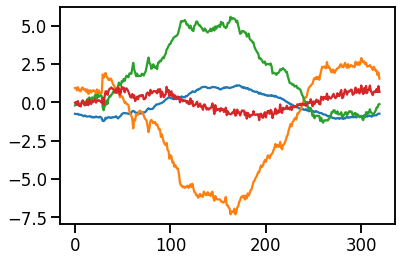

In [29]:
plt.plot(final_samples[0]['cycle_1']['I_30db']);

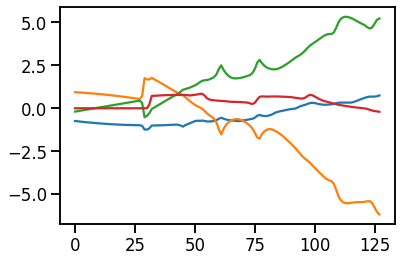

In [ ]:
plt.plot(final_samples[0]['cycle_4']['I_pu']);

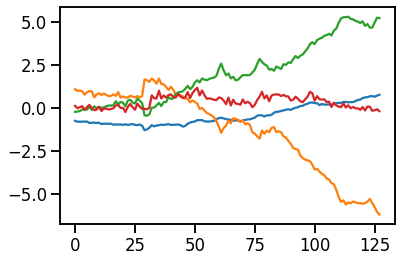

In [ ]:
plt.plot(final_samples[0]['cycle_4']['I_30db']);

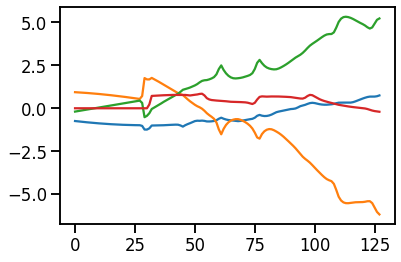

In [ ]:
plt.plot(final_samples[0]['cycle_4']['I_100db']);

In [ ]:
# A B C T >>> falta BCT: [0, 1, 1, 1]
def convert_label(label):
    mlb = MultiLabelBinarizer()
    mlb.fit(['A', 'B', 'C', 'T'])
    return pd.DataFrame(mlb.transform(np.array([label])))

In [ ]:
for data in final_samples:
    label = data['fault_type']
    out_vector = convert_label(label)
    data['fault_type_bin'] = out_vector

In [ ]:
final_samples[100].keys()

dict_keys(['fault_type', 'cycle_1', 'cycle_2', 'cycle_4', 'cycle_8', 'cycle_16', 'cycle_32', 'fault_type_bin'])

In [ ]:
final_samples[50]['fault_type']

'ABT'

In [ ]:
final_samples[50]['fault_type_bin']

,0,1,2,3
0,1,1,0,1


In [ ]:
with open(data_path + 'noise_data_current2.pkl','wb') as f:
    data = pickle.dump(final_samples, f)

In [ ]:
with open(data_path + 'noise_data_current2.pkl','rb') as f:
    data = pickle.load(f)

In [ ]:
len(data)

940